In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import string
import os

from keras.layers            import Activation, Dense, Dropout
from keras.models            import Sequential
from keras.optimizers        import SGD
from keras.utils.np_utils    import to_categorical
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import accuracy_score, confusion_matrix 
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.svm             import SVC                                             as SVM
from sklearn.tree            import DecisionTreeClassifier                          as Tree

from utility import plot_confusion_matrix, plot_img_dataset, load_hyperopt_out

Using TensorFlow backend.


# 4. Reconocimiento de Imágenes Sign Gestures

En esta sección, se estudiará el comportamiento de distintos modelos en la tarea de clasificar imágenes, en especifico se utilizará el conjunto de imágenes Sign Language MNIST, este conjunto de imágenes se compone de imágenes de 28x28 pixeles, donde cada imagen corresponde a la representación de las letras del abecedario en el lenguaje de señas. El conjunto se compone de 27455 imágenes para el conjunto de entrenamiento y 7172 para el conjunto de pruebas. Cada imagen del conjunto pertenece a una única etiqueta, la cual pertenece al conjunto de números enteros [0, 25], y corresponden a cada letra del abecedario (A-Z). Dadas las limitaciones de la representación del conjunto de imágenes se incluyen, no se incluyen imágenes con las etiquetas 9 (J) y 25 (Z), debido a que estas letras incluyen movimiento en su representación. 

A continuación se muestran algunos elementos del conjunto de imágenes,  agrupados por etiqueta.

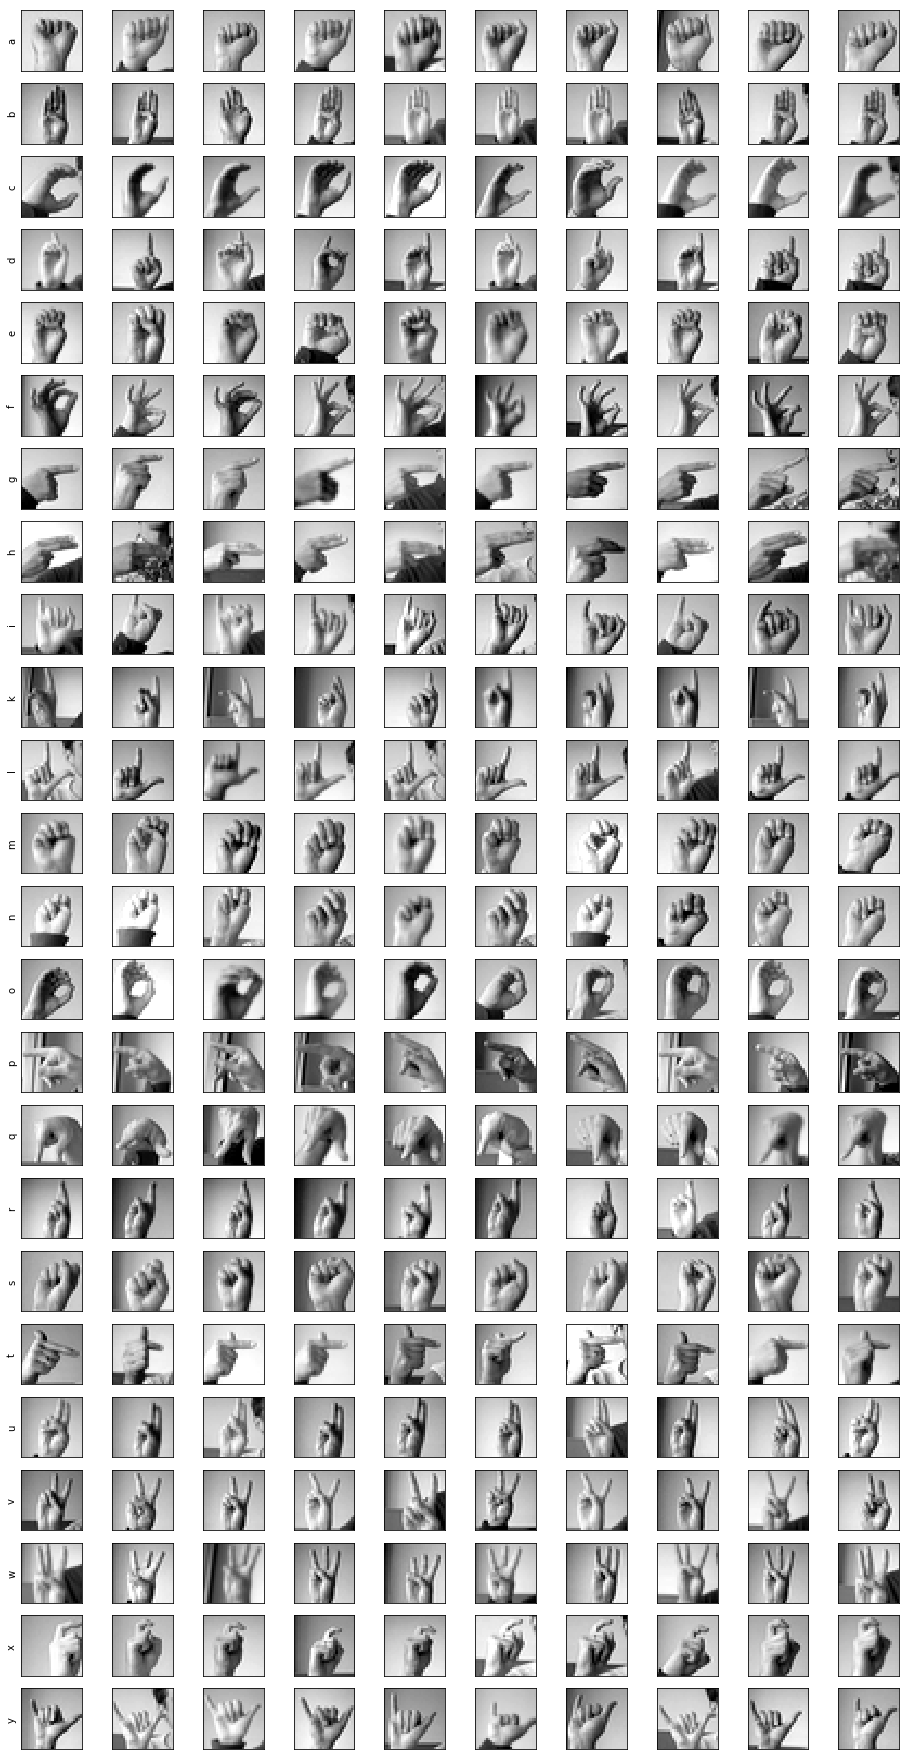

In [4]:
plot_img_dataset(x_tr, y_tr, labels, classes_names=labels_names, _figsize=(16, 32))

Ha de señalarse que el conjunto de imágenes fue generado a partir de un conjunto más pequeño (1704 elementos), y para aumentar la cantidad de registros se aplicaron diversas estrategias, entre las cuales se encuentran: aplicar filtros ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), realizar un 5% de pixelacion automática, modificación en un +/- 15% en el brillo o el contraste, y una rotación en 3 grados. Las trasformaciones anteriores se consideran efectivas para crear nuevos ejemplos de las clases debido al pequeño tamaño de las imágenes, permitiendo una mejor separación de las clases. 

## a) Construya una función que cargue todos los datos de entrenamiento y pruebas del problema generando como salida: 
1. Dos matrices Xtr; Ytr, correspondientes a las imágenes y etiquetas de entrenamiento.
2. Dos matrices Xt; Yt, correspondientes a las imágenes y etiquetas de pruebas.
3. Dos matrices Xv; Yv, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo.

Se crea la función load_data, la cual se encarga de generar los conjuntos de entrenamiento, pruebas y validación, este ultimo si es generado se genera con un 25% de los datos del conjunto de entrenamiento. La función posee los siguientes parámetros:
- base_path: Ruta donde se encuentran los archivos del conjunto de datos, por defecto es ‘data/sign-language-mnist’
- test: Si se genera el conjunto de testeo, por defecto True.
- validation: Si se genera el conjunto de validación, por defecto True.

In [2]:
def load_data(base_path = os.path.join('data', 'sign-language-mnist'), validation=True, test=True):
    # read train set
    train_data = pd.read_csv(os.path.join(base_path,  'sign_mnist_train.csv'))
    y_tr = train_data['label'].as_matrix()
    x_tr = train_data.iloc[:,1:].as_matrix()
    out = [x_tr, y_tr]
    # read test set
    if test:
        test_data = pd.read_csv(os.path.join(base_path,  'sign_mnist_test.csv'))
        y_t = test_data['label'].as_matrix()
        x_t = test_data.iloc[:,1:].as_matrix()
        out.append(x_t)
        out.append(y_t)
    # split train set into train and validation set
    if validation:
        x_tr, x_v, y_tr, y_v = train_test_split(x_tr, y_tr, test_size=0.25, random_state=42)
        out[0] = x_tr
        out[1] = y_tr
        out.append(x_v)
        out.append(y_v)
    return tuple(out)

In [3]:
x_tr, y_tr, x_t, y_t, x_v, y_v = load_data()
x_tr_f, y_tr_f = load_data(validation=False, test=False)

Se generan los conjuntos de entrenamiento, pruebas y validación. Los conjuntos generados no poseen elementos en común, además el tamaño de estos es $20591$ registros para el conjunto de entrenamiento, $7172$ para el conjunto de pruebas y $6864$ para el conjunto de validación.

Finalmente se genera un conjunto de entrenamiento con todos los elementos del archivo ‘sign_mnist_train.csv’. Este conjunto será utilizado para entrenar los modelos finales o los entrenados mediante k-fold validation.

In [4]:
# Conjunto de etiquetas del problema
labels = list(set(y_t))
labels_names = [i for i in string.ascii_lowercase]
labels_names.remove('j')
labels_names.remove('z')

## b) Construya una función que escale apropiadamente las imágenes antes de trabajar. Experimente sólo escalando los datos de acuerdo a la intensidad máxima de pixel y luego centrando y escalándolos como en actividades anteriores.


Se crea la función scaler_function, la cual por defecto  la intensidad de los pixeles de la imagen dividiéndolos en 255, con el objetivo de que la intensidad por pixel pertenezca al intervalo [0, 1]. La función también permite centrar y escalar la los datos, utilizando un StandardScaler, si el parámetro scale es verdadero se escalaran y centraran los datos, si el parámetro std es falso solo se escalaran.

In [8]:
def scaler_function(x_train, x_test=None, x_val=None, scale=False, std=True):
    x_train = x_train.astype('float64')
    x_train /= 255.
    scaler = StandardScaler(with_std=std).fit(x_train)
    if scale:
        x_train = scaler.transform(x_train)
    out = [x_train]
    if not x_test is None:
        x_test = x_test.astype('float64')
        x_test /= 255.
        if scale:
            x_test = scaler.transform(x_test)
        out.append(x_test)
    if not x_val is None:
        x_val = x_val.astype('float64')
        x_val /= 255.
        if scale:
            x_val = scaler.transform(x_val)
        out.append(x_val)
    return tuple(out) if 1<len(out) else out[0]

Se ajustan las intensidades de los 4 conjuntos anteriormente creados:

In [9]:
# Conjuntos usados para evaluar
x_train, x_test, x_val = scaler_function(x_tr, x_t, x_v)
# Conjunto usados para el entrenamiento del modelo 'final'
x_train_full = scaler_function(x_tr_f)

Además, se crean otros cuatro conjuntos a partir de los conjuntos originales. A los nuevos conjuntos se les ajusta la intensidad, y se escalan utilizando el StandardScaler. 

In [10]:
x_train_center, x_val_center, x_test_center = scaler_function(x_tr, x_v, x_t, scale=True)
x_train_full_center = scaler_function(x_tr_f, scale=True)

## c) Diseñe, entrene y evalúe una red neuronal para el problema partir de la representación original de las imágenes. Experimente con distintas arquitecturas, pre-procesamientos y métodos de entrenamiento, midiendo el error de clasificación sobre el conjunto de validación. En base a esta última medida de desempeño, decida que modelo, de entre todos los evaluados, medirá finalmente en el conjunto de test. Reporte y discuta los resultados obtenidos. 

Para determinar que arquitectura y elección de preprocesamiento es la mas adecuada para resolver el problema de clasificar las imágenes del conjunto de datos, primero se enfocaron los esfuerzos en determinar que estructuras o patrones de estructuras son beneficiosos para la resolución del problema. 

La primera tarea realizada consistió en utilizar la librería *Hyperas*, la cual es un sintonizador de parámetros para modelos de redes neuronales basados en la librería *Keras*. Utilizando el conjunto de datos, donde la intensidad de cada pixel fue dividida por 255, se entrenaron 75 redes neuronales, de las cuales los parámetros a sintonizar fueron:
- Tamaño de la primera capa, valor numérico con las opciones (30, 45, 60) neuronas.
- Función de activación primera capa, donde las opciones posibles fueron [relu, elu]
- Tamaño de la segunda capa, con las mismas opciones que la primera capa.
- Función de activación de la segunda capa, con las mismas opciones de la primera capa.
- Si se agrega una tercera capa, valor booleano (True, False)
- Si se agrega una tercera capa, el tamaño de estas con las mismas opciones de las capas anteriores.
- Si se agrega una tercera capa, la función de activación de esta, con las mismas opciones que las capas anteriores.
- Optimizador a utilizar en el entrenamiento de la red, donde las opciones fueron rmsprop, adam, sgd.
- El tamaño del batch utilizado para actualizar los pesos de la red, donde los valores posibles fueron 64 y 128.

Para la elección de las mejores estructuras se utilizó el conjunto de validación, previamente construido. Y el código correspondiente se encuentra en el archivo ‘test.py’ ya que no fue posible ejecutar satisfactoriamente la librería en el notebook.

A continuación, se muestran algunos de los mejores resultados obtenidos. A de señalarse que siempre están presente los valores del tamaño y función de activación de la tercera capa, pero si no se eligió agregar dicha capa, estos valores no se tienen en cuenta.

In [12]:
import pprint

hyp_out = load_hyperopt_out('trial.json')
pprint.pprint(hyp_out[0])
pprint.pprint(hyp_out[2])
pprint.pprint(hyp_out[4])
pprint.pprint(hyp_out[6])
pprint.pprint(hyp_out[8])

{'conf': {'Dense': 45,
          'Dense_1': 60,
          'Dense_2': 60,
          'Dropout': 0.2504909167727587,
          'Dropout_1': 0.04055836586938495,
          'Dropout_2': 0.7170109682276645,
          'activation': 'elu',
          'activation_1': 'relu',
          'activation_2': 'relu',
          'batch_size': 128,
          'conditional': False,
          'optimizer': 'adam'},
 'loss': -0.9998543123543123}
{'conf': {'Dense': 45,
          'Dense_1': 60,
          'Dense_2': 60,
          'Dropout': 0.26575371035061834,
          'Dropout_1': 0.0638174825649742,
          'Dropout_2': 0.8560325910603621,
          'activation': 'elu',
          'activation_1': 'relu',
          'activation_2': 'relu',
          'batch_size': 128,
          'conditional': False,
          'optimizer': 'adam'},
 'loss': -0.9997086247086248}
{'conf': {'Dense': 45,
          'Dense_1': 60,
          'Dense_2': 60,
          'Dropout': 0.21772733016930734,
          'Dropout_1': 0.31899443452607

De los resultados obtenidos mediante el sintonizador, es posible apreciar que los mejores modelos obtenidos poseen 2 capas intermedias. Para la primera capa intermedia se elige un tamaño de 45 neuronas y la función de activación *elu*, para la segunda capa determino un tamaño de 60 neuronas y la función de activación *relu*. De los valores de Dropout se aprecia que estos no superan el 30%. El método de entrenamiento con mejores resultados fue *adam* y finalmente el tamaño del batch igual a 128.

Al comparar estos resultados con una de las propuestas de red presentes en kaggle, se hace evidente la diferencia entre los tamaños de las capas elegidas,  ya que el modelo presente en kaggle corresponde a una red de dos capas intermedias, donde la primera posee 256 neuronas, una función de activación *relu*, dropout de un 40% y la segunda capa posee 128 neuronas, función de activación *relu* y dropout de 30%.

De la comparación con la red en kaggle, se propone evaluar 4 modelos de red con capas intermedias mas grandes, donde el tamaño de cada intermedia capa disminuye a medida que se avanza en la red, y las funciones de activación serian *elu*, a excepción de la ultima capa intermedia que correspondería a una *relu*, ya que se trata de seguir los resultados obtenidos por el sintonizador. 

Se crea la función build_model, la cual recibe una configuración de una red mediante un diccionario para simplificar la creación y evaluación de las redes

In [94]:
def build_model(conf, _input_dim):
    model = Sequential()
    model.add(Dense(conf['Dense'][0], input_dim=_input_dim, activation=conf['activation'][0], kernel_initializer='uniform'))
    model.add(Dropout(conf['Dropout'][0]))
    for i in range(1,conf['layers']):
        model.add(Dense(conf['Dense'][i], activation=conf['activation'][i], kernel_initializer='uniform'))
        model.add(Dropout(conf['Dropout'][i]))
    model.add(Dense(25, activation='softmax', kernel_initializer='uniform'))
    # Compile model
    model.compile(optimizer=conf['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Se definen los 4 modelos a evaluar, donde el campo layers indica la cantidad de capas intermedias, Dense el tamaño de estas capas, Dropout los valores para los dropout de cada capa, activation las funciones de activación de cada capa, optimizer el método para entrenar la red, y finalmente batch_size que es el tamaño del batch en el entrenamiento. 

In [10]:
list_conf = [
    { 
        'id': 0, 'layers': 2, 'Dense': [128, 64], 'Dropout': [.20, .15],
        'activation': ['elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
    { 
        'id': 1, 'layers': 3, 'Dense': [256, 128, 64], 'Dropout': [.25, .20, .15],
        'activation': ['elu', 'elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
    { 
        'id': 2, 'layers': 4, 'Dense': [512, 256, 128, 64], 'Dropout': [.30, .25, .20, .15],
        'activation': ['elu','elu', 'elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
    { 
        'id': 3, 'layers': 4, 'Dense': [512, 256, 128, 64], 'Dropout': [.25, .20, .15, .10],
        'activation': ['elu','elu', 'elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
]

Se evalúan los modelos creados mediante 5-Fold validation.

In [98]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
base = ' - '
hist = [[] for _ in range(4)]

for conf in list_conf:
    cvscores = []
    loss_out = None
    acc_out = None
    for train, test in kfold.split(x_train_full, y_tr_f):
        model = build_model(conf, x_train.shape[1])
        history = model.fit(x_train_full[train], to_categorical(y_tr_f[train]), epochs=100, batch_size=128, verbose=0,
                   validation_data=(x_train_full[test], to_categorical(y_tr_f[test])))
        hist[conf['id']].append(history)
        # evaluate the model
        scores = model.evaluate(x_train_full[test], to_categorical(y_tr_f[test]), verbose=0)
        cvscores.append(scores[1]*100)
        acc_cur = "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100)
        acc_out = base.join([acc_out, acc_cur]) if acc_out else acc_cur
        loss_cur = "%s: %.3f" % (model.metrics_names[0], scores[0])
        loss_out = base.join([loss_out, loss_cur]) if loss_out else loss_cur
    print('--------------------------- 5-fold id: %i ---------------------------' % conf['id'])
    print(loss_out)
    print(acc_out)
    print("acc fold: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

--------------------------- 5-fold id: 0 ---------------------------
loss: 0.004 - loss: 0.004 - loss: 0.009 - loss: 0.005 - loss: 0.003
acc: 99.91% - acc: 99.96% - acc: 99.80% - acc: 99.95% - acc: 100.00%
acc fold: 99.92% (+/- 0.07%)
--------------------------- 5-fold id: 1 ---------------------------
loss: 0.001 - loss: 0.001 - loss: 0.005 - loss: 0.004 - loss: 0.013
acc: 100.00% - acc: 100.00% - acc: 99.87% - acc: 99.98% - acc: 99.47%
acc fold: 99.87% (+/- 0.20%)
--------------------------- 5-fold id: 2 ---------------------------
loss: 0.001 - loss: 0.024 - loss: 0.003 - loss: 0.001 - loss: 0.001
acc: 100.00% - acc: 99.33% - acc: 99.95% - acc: 99.96% - acc: 100.00%
acc fold: 99.85% (+/- 0.26%)
--------------------------- 5-fold id: 3 ---------------------------
loss: 0.003 - loss: 0.003 - loss: 0.002 - loss: 0.002 - loss: 0.005
acc: 99.93% - acc: 99.93% - acc: 99.95% - acc: 99.96% - acc: 99.89%
acc fold: 99.93% (+/- 0.02%)


Se los resultados obtenidos con 5-Fold validation, se aprecia que todos los modelos en promedio obtienen accuracy sobre el 99%. El modelo elegido corresponde al ultimo ya que en promedio obtiene una accuracy mayor y una varianza menor los otros modelos evaluados, lo cual se puede interpretar que el modelo es mas robusto, además de obtener resultados similares para distintos conjuntos de entrenamiento, indicando que independientemente de los datos utilizador para entrenar, el modelo aprende cualidades útiles para distinguir los elementos del conjunto a clasificar.

Se realizan los gráficos de la accuracy y loss de los modelos en función del número de epoch

In [100]:
def plot_learning_curve(history_fold):
    n_plots = len(history_fold)
    x = len(hist[0][0].history['acc'])
    x_space = np.linspace(1, x, x)

    f, axarr = plt.subplots(n_plots, 2,figsize=(16,5*n_plots))
    for i in range(n_plots):
        train_acc = [hist[i][j].history['acc'] for j in range(5)]
        train_loss = [hist[i][j].history['loss'] for j in range(5)]
        val_acc = [hist[i][j].history['val_acc'] for j in range(5)]
        val_loss = [hist[i][j].history['val_loss'] for j in range(5)]

        train_acc_mean = np.mean(train_acc, axis=0)
        train_acc_std = np.std(train_acc, axis=0)
        train_loss_mean = np.mean(train_loss, axis=0)
        train_loss_std = np.std(train_loss, axis=0)
        val_acc_mean = np.mean(val_acc, axis=0)
        val_acc_std = np.std(val_acc, axis=0)
        val_loss_mean = np.mean(val_loss, axis=0)
        val_loss_std = np.std(val_loss, axis=0)

        axarr[i, 0].grid(True, linestyle='dashed')
        axarr[i, 0].fill_between(x_space, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, alpha=0.25, color="r")
        axarr[i, 0].fill_between(x_space, val_acc_mean - val_acc_std, val_acc_mean + train_acc_std, alpha=0.25, color="g")
        axarr[i, 0].plot(x_space, train_acc_mean, marker='.', linestyle='--', color="r", label="Training score")
        axarr[i, 0].plot(x_space, val_acc_mean, marker='.', linestyle='--', color="g", label="Cross-validation score")
        axarr[i, 0].set_xlabel('epoch')
        axarr[i, 0].set_ylabel('accuracy')
        axarr[i, 0].legend(loc='lower right')
        
        axarr[i, 1].grid(True, linestyle='dashed')
        axarr[i, 1].fill_between(x_space, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.25, color="r")
        axarr[i, 1].fill_between(x_space, val_loss_mean - val_loss_std, val_loss_mean + train_loss_std, alpha=0.25, color="g")
        axarr[i, 1].plot(x_space, train_loss_mean, marker='.', linestyle='--', color="r", label="Training score")
        axarr[i, 1].plot(x_space, val_loss_mean, marker='.', linestyle='--', color="g", label="Cross-validation score")
        axarr[i, 1].set_xlabel('epoch')
        axarr[i, 1].set_ylabel('loss')
        axarr[i, 1].legend(loc='upper right')
    plt.show()
    

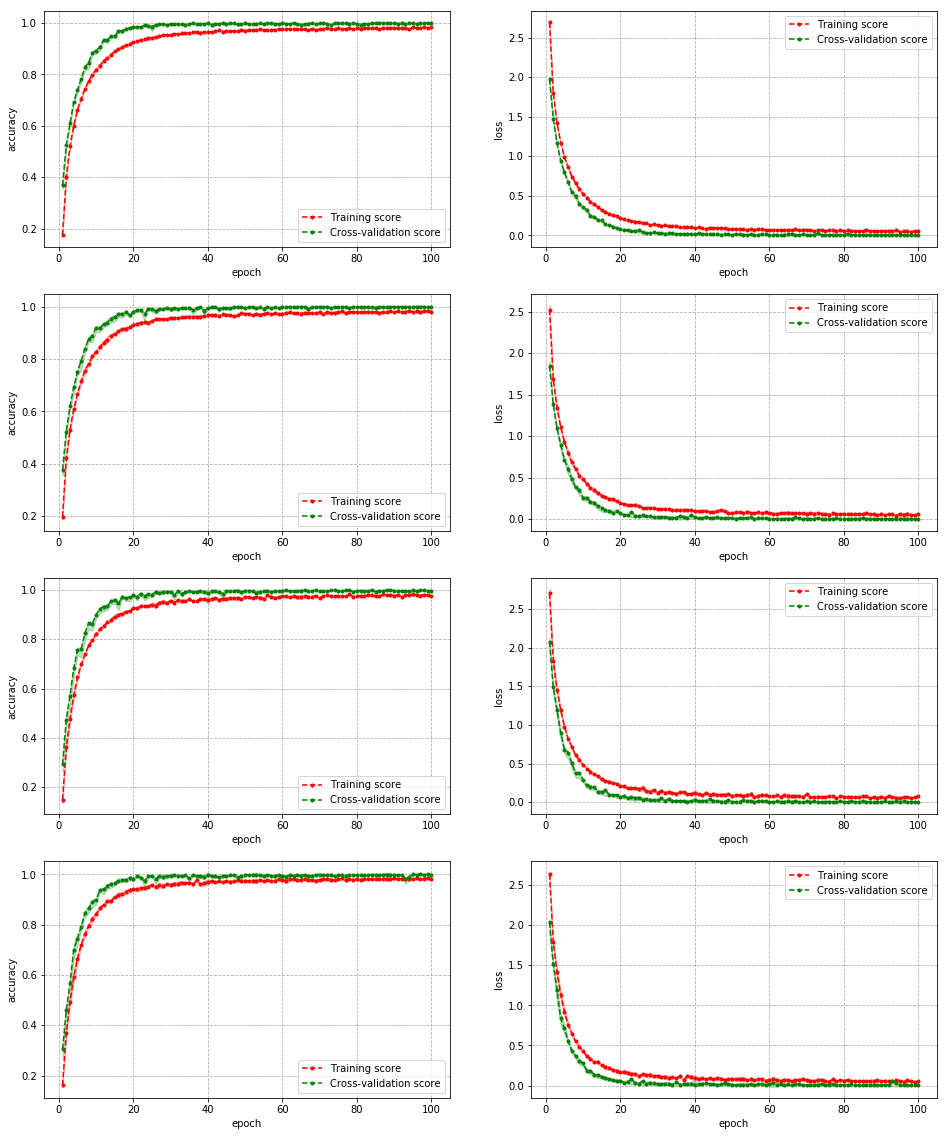

In [101]:
plot_learning_curve(hist)

De los gráficos anteriores, se aprecia que no existen irregularidades en el entrenamiento de las redes, y que la convergencia de estas a un óptimo local fue continua.

Se procede a entrenar el modelo seleccionado con todos los elementos del conjunto de entrenamiento, y se evalúa su rendimiento en el conjunto de test. OBS: se utiliza el conjunto de entrenamiento como validación en el fit, ya que el modelo ya fue elegido.

In [84]:
best_conf = {
    'layers': 4,
    'Dense': [512, 256, 128, 64],
    'Dropout': [.25, .20, .15, .10],
    'activation': ['elu','elu', 'elu', 'relu'],
    'batch_size': 128,
    'optimizer': 'adam'
}

model = build_model(best_conf, x_train.shape[1])
model.summary()
history = model.fit(x_train_full, to_categorical(y_tr_f), epochs=100, batch_size=128, verbose=2,
                   validation_data=(x_test, to_categorical(y_t)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_208 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_159 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_209 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_160 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_210 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_161 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_211 (Dense)            (None, 64)                8256      
__________

Epoch 79/100
 - 7s - loss: 0.0761 - acc: 0.9771 - val_loss: 1.1092 - val_acc: 0.8166
Epoch 80/100
 - 8s - loss: 0.0529 - acc: 0.9844 - val_loss: 1.0705 - val_acc: 0.8180
Epoch 81/100
 - 7s - loss: 0.0447 - acc: 0.9859 - val_loss: 1.1542 - val_acc: 0.8229
Epoch 82/100
 - 7s - loss: 0.0674 - acc: 0.9796 - val_loss: 1.1524 - val_acc: 0.8104
Epoch 83/100
 - 7s - loss: 0.0492 - acc: 0.9856 - val_loss: 1.0428 - val_acc: 0.8353
Epoch 84/100
 - 7s - loss: 0.0264 - acc: 0.9925 - val_loss: 1.1569 - val_acc: 0.8225
Epoch 85/100
 - 8s - loss: 0.0765 - acc: 0.9777 - val_loss: 1.1431 - val_acc: 0.8095
Epoch 86/100
 - 7s - loss: 0.0342 - acc: 0.9894 - val_loss: 1.1867 - val_acc: 0.8161
Epoch 87/100
 - 7s - loss: 0.0724 - acc: 0.9782 - val_loss: 1.1342 - val_acc: 0.8182
Epoch 88/100
 - 8s - loss: 0.0357 - acc: 0.9891 - val_loss: 1.1113 - val_acc: 0.8320
Epoch 89/100
 - 8s - loss: 0.0455 - acc: 0.9867 - val_loss: 1.1387 - val_acc: 0.8183
Epoch 90/100
 - 7s - loss: 0.0669 - acc: 0.9795 - val_loss: 0.951

El modelo elegido logra un 83,51% de precisión sobre el conjunto de test. Se observa que el modelo llega logra en pocos epoch una accuracy del 90% en el entrenamiento, y que la accuracy en el conjunto de test aumenta gradualmente hasta llegar al 83,51%, indicando que el modelo aprende de manera gracual las cualidades que le permiten clasificar las distintas clases.

Se procede a entrenar el modelo elegido con el conjunto de datos centrados para evaluar la influencia del procesado en el modelo.

In [106]:
# x scales
best_conf = {
    'layers': 4,
    'Dense': [512, 256, 128, 64],
    'Dropout': [.25, .25, .20, .15],
    'activation': ['elu','elu', 'elu', 'relu'],
    'batch_size': 128,
    'optimizer': 'adam'
}

model = build_model(best_conf, x_train.shape[1])
model.summary()
history = model.fit(x_train_full_center, to_categorical(y_tr_f), epochs=100, batch_size=128, verbose=2,
                   validation_data=(x_test_center, to_categorical(y_t)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_338 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_260 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_339 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_261 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_340 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_262 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_341 (Dense)            (None, 64)                8256      
__________

Epoch 79/100
 - 8s - loss: 0.0265 - acc: 0.9950 - val_loss: 1.5821 - val_acc: 0.8341
Epoch 80/100
 - 8s - loss: 0.0134 - acc: 0.9968 - val_loss: 1.5202 - val_acc: 0.8362
Epoch 81/100
 - 8s - loss: 0.0256 - acc: 0.9949 - val_loss: 1.7143 - val_acc: 0.8172
Epoch 82/100
 - 9s - loss: 0.0185 - acc: 0.9961 - val_loss: 1.3784 - val_acc: 0.8508
Epoch 83/100
 - 8s - loss: 0.0049 - acc: 0.9986 - val_loss: 1.5336 - val_acc: 0.8380
Epoch 84/100
 - 8s - loss: 0.0221 - acc: 0.9951 - val_loss: 1.5967 - val_acc: 0.8257
Epoch 85/100
 - 9s - loss: 0.0087 - acc: 0.9976 - val_loss: 1.4477 - val_acc: 0.8473
Epoch 86/100
 - 8s - loss: 0.0125 - acc: 0.9970 - val_loss: 1.4809 - val_acc: 0.8348
Epoch 87/100
 - 8s - loss: 0.0150 - acc: 0.9968 - val_loss: 1.4545 - val_acc: 0.8381
Epoch 88/100
 - 8s - loss: 0.0130 - acc: 0.9972 - val_loss: 1.6874 - val_acc: 0.8257
Epoch 89/100
 - 8s - loss: 0.0214 - acc: 0.9953 - val_loss: 1.5600 - val_acc: 0.8339
Epoch 90/100
 - 8s - loss: 0.0106 - acc: 0.9973 - val_loss: 1.683

Al evaluar el modelo entrenado se obtiene un 83,91% de precisión sobre el conjunto de test, indicando que el centrado de los datos no aporta información para la red neuronal, además se aprecia que el modelo es lo suficientemente robusto para obtener resultados de buena calidad, ya que, si se utilizaran funciones de activación *relu*, los pixeles trasformados menores a cero de un registro causarían problemas en el entrenamiento de la red, lo cual no ocurre con la función de entrenamiento elegida para las primeras capas ocultas.

## d) Para la mejor red entrenada anteriormente construya la matriz de confusión de las distintas clases, para asi visualizar cuáles son las clases más dificiles de clasificar y con cuáles se confunden.


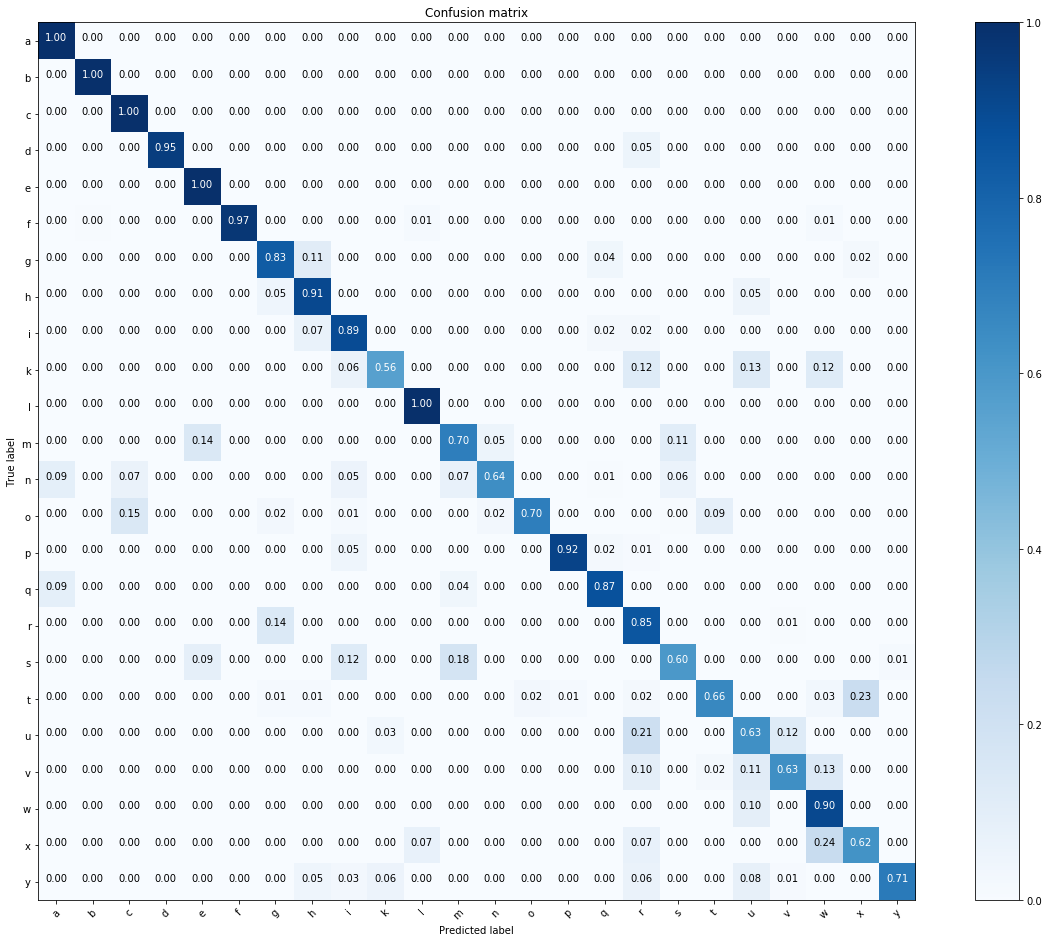

In [44]:
y_precit = model.predict_classes(x_test)
cm = confusion_matrix(y_t, y_precit)

plt.figure(figsize=(17,13))
plot_confusion_matrix(cm, labels_names, normalize=True)
plt.show()

De la matriz de confusión del mejor modelo, se aprecia que clase con el peor rendimiento es la $k$, la cual es confundida con las clases $r$, $u$, y $w$, al comparar estas clases se aprecia las cuatro clases poseen elementos en común, uno de estos es el levantar uno o más dedos hacia arriba, seguramente el modelo distingue ‘algo’ apuntando hacia arriba pero no es capaz de distinguir si es un solo dedo o más de un dedo. Otro elemento en común es que no muestran la palma de la mano o esta queda oculta por los dedos de la mano, lo cual puede indicar que el modelo distingue la forma circular que forma la mano (sin considerar los dedos que apuntan hacia arriba) que presentan estas letras. De igual manera se observan confusiones por parte del modelo con formas similares, por ejemplo la $m$ con la $s$.

## e) Entrene una SVM no lineal sobre los pixeles con y sin pre-procesamiento.

Para continuar con el estudio de la calificación de imágenes, se procede a evaluar el rendimiento de utilizar una SVM como modelo de clasificación. Para elegir el mejor modelo se evaluaron SVM con kernels *poly*, *rbf*, y *sigmoid*, y valor de regularización C entre $10^i$ tal que $-2 \leq i \leq 4$, en los conjuntos con pre-procesamiento de escalado, centrado y el conjunto sin pre-procesamiento.

In [53]:
def plot_grid_out(out, c, l, x_space, xscale='log', ylabel='C'):
    pl = ['train', 'test']
    f, axarr = plt.subplots(1, 2, figsize=(17,5))
    base = len(c)
    count = int(len(out['mean_test_score'])/2)
    for k in range(2):
        axarr[k].set_xscale(xscale)
        axarr[k].set_xlabel(ylabel)
        axarr[k].set_ylabel('accuracy')
        for i in range(base):
            m = np.array([out['mean_'+pl[k]+'_score'][i+base*j] for j in range(count)])
            s = 2*np.array([out['std_'+pl[k]+'_score'][i+base*j] for j in range(count)])
            axarr[k].grid(True, linestyle='dashed')
            axarr[k].fill_between(x_space, m - s, m + s, alpha=0.25, color=c[i])
            axarr[k].plot(x_space, m, marker='o', linestyle='--', color=c[i], label=pl[k]+' score '+l[i])
            axarr[k].legend(loc='lower right')
    plt.show()

### 1) Datos escalados

Dada la complejidad del entrenamiento de una SVM, como se señala en la documentación de sklearn:

    “The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.”

Se crea un sub conjunto de datos de entrenamiento, con un 13% de los datos de entrenamiento originales, para facilitar la elección de los hiper parámetros del modelo.

In [135]:
_, x_sub, _, y_sub = train_test_split(x_train, y_tr, test_size=0.13, random_state=42)

Para la selección de los hiper parámetros se utiliza la clase *GridSearchCV* de sklern, la cual realiza una búsqueda exhaustiva dentro del espacio de búsqueda señalado.

In [136]:
tuned_parameters = [{
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'kernel': ['poly', 'rbf', 'sigmoid'],
}]

clf = GridSearchCV(SVM(), tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_sub, y_sub)
clf.best_params_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 63.7min finished


{'C': 1000, 'kernel': 'rbf'}

In [187]:
clf.best_score_

0.96115054165110203

El mejor modelo entrenado con una SVM utilizando los datos escalados, corresponde a la SVM con kernel *rbf* y C igual a 1000. Logrando un 96,12% en promedio sobre el conjunto de validación.

Para analizar con mayor claridad los resultados se realizan los gráficos de error de entrenamientos y pruebas en función del valor de C, para los 3 kernels usados .

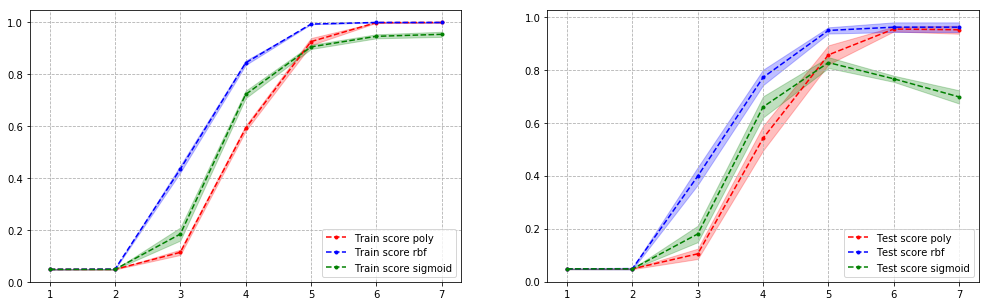

In [190]:
c = ['r', 'b', 'g']
l = ['poly', 'rbf', 'sigmoid']
x_space = [0.01, 0.1, 1, 10, 100, 1000, 10000]
plot_grid_out(clf.cv_results_, c, l, x_space)

Se observa que el kernel *sigmoid* obtiene los resultados más bajos, y que con C igual a 1.000 y 10.000 se presenta un claro overfiting en el modelo. De los kernels *poly* y *rbf* ambos con C igual a 1.000 y 10.000 logran una accuracy del 100% en el conjunto de entrenamiento y en el conjunto de validación el kernel *rbf* contiene un resultado levemente mayor que el *poly*, pero debido a la superposición de los rangos de sus varianzas, seguramente no exista evidencia suficiente para decir que el kernel *rbf* obtiene mejores resultados que el kernel *poly*

### 2) Datos centrados

Ahora se prueba el rendimiento de una SVM con los datos centrados. De igual manera que con los datos escalados, se crea un sub conjunto para realizar la evaluación del modelo.

In [191]:
_, x_sub_center, _, y_sub_center = train_test_split(x_train_center, y_tr, test_size=0.13, random_state=42)

In [192]:
tuned_parameters = [{
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'kernel': ['poly', 'rbf', 'sigmoid'],
}]

clf = GridSearchCV(SVM(), tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_sub_center, y_sub_center)
clf.best_params_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 77.2min finished


{'C': 100, 'kernel': 'rbf'}

In [193]:
clf.best_score_

0.93799028763541281

El mejor modelo corresponde al que usa un kernel *rbf* y factor de regularización C igual a 100, con un promedio de accuracy sobre el conjunto de validación igual a 93,79%.

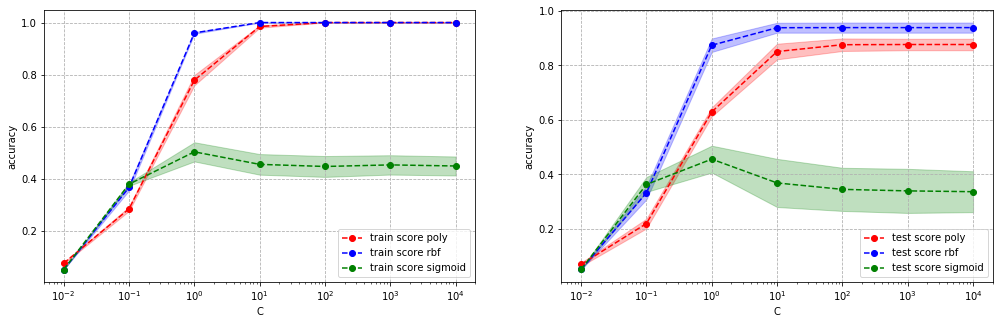

In [228]:
plot_grid_out(clf.cv_results_, c, l, x_space)

Al igual que con conjunto de datos escalados, el kernel sigmoid obtiene los peores resultados, además se observa que la varianza de este modelo es de mayor magnitud en comparación a los otros dos modelos. El kernel *rbf* obtiene un mejor rendimiento que uno *poly* para todos los valores probados de C, y se observa que *rbf* efectivamente obtiene mejores resultados que *poly*.

### 3) Datos sin procesar

Finalmente se crea un subconjunto de datos con los datos sin procesar y se evalúa el rendimiento de la SVM sobre este.

In [8]:
_, x_sub_unp, _, y_sub_unp = train_test_split(x_tr, y_tr, test_size=0.13, random_state=42)

In [232]:
tuned_parameters = [{
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'kernel': ['poly', 'rbf', 'sigmoid'],
}]

clf = GridSearchCV(SVM(), tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_sub_unp, y_sub_unp)
clf.best_params_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 73.7min finished


{'C': 0.01, 'kernel': 'poly'}

In [233]:
clf.best_score_

0.95069107209562942

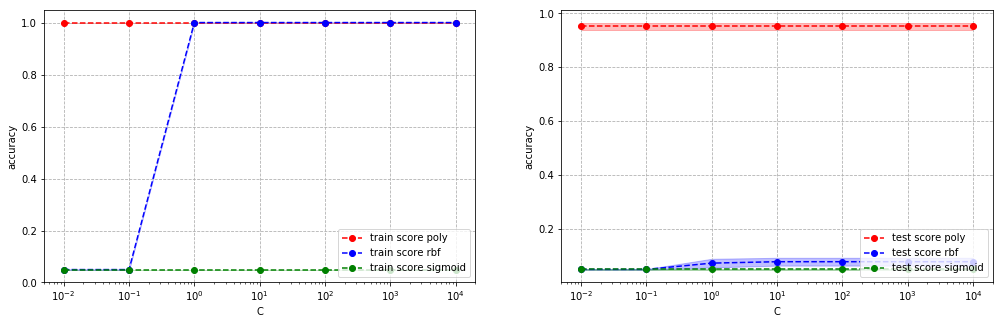

In [234]:
plot_grid_out(clf.cv_results_, c, l, x_space)

De los resultados del modelo entrenado con los datos sin procesar, se aprecia que los modelos rbf y sigmoid no son capaces de aprender las cualidades del conjunto de entrenamiento, y del modelo con kernel poly es posible que la trasformación sea favorable, ya que se logran buenos resultados independientemente del valor de C.

### 4) Modelo final
Se procede a entrenar una SVM con kernel *rbf*, C igual a 1000, y utilizando el conjunto de entrenamiento escalado.

In [9]:
model = SVM(probability=True)
model.set_params(C=1000, kernel='rbf', verbose=True)
model.fit(x_train_full, y_tr_f)

[LibSVM]

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [11]:
y_pred = model.predict(x_train_full)
acc_test = 100*accuracy_score(y_tr_f, y_pred)
print('Accuracy on test: %.2f%%' % (acc_test))
y_pred = model.predict(x_test)
acc_test = 100*accuracy_score(y_t, y_pred)
print('Accuracy on train: %.2f%%' % (acc_test))

Accuracy on test: 100.00%
Accuracy on train: 79.50%


El modelo final obtiene un 79.50% de precisión sobre el conjunto de test, lo cual es levemente menor al resultado obtenido en la sección anterior.

## f) Entrene una árbol de clasificación sobre los pixeles con y sin pre-procesamiento. 

### 1) Datos escalados

In [48]:
_, x_sub, _, y_sub = train_test_split(x_train, y_tr, test_size=0.20, random_state=42)

In [50]:
tuned_parameters = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(2, 25)]
}]

clf = GridSearchCV(Tree(), tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_sub, y_sub)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed: 65.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [62]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 19}

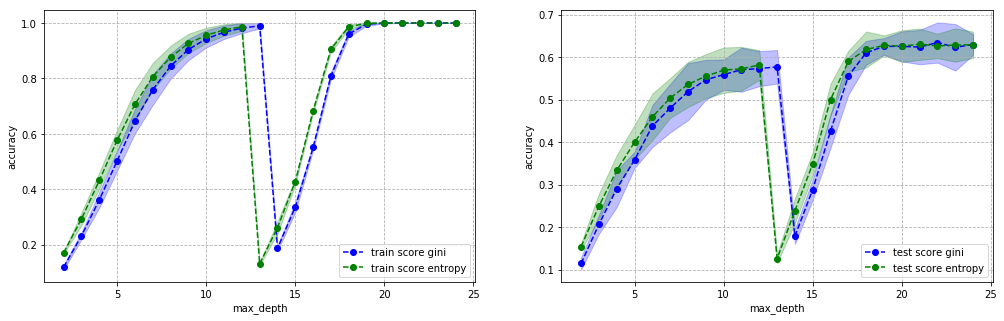

In [54]:
c = ['b', 'g']
l = ['gini', 'entropy']
x_space = [i for i in range(2, 25)]
plot_grid_out(clf.cv_results_, c, l, x_space, xscale='linear', ylabel='max_depth')

### 2) Datos centrados

In [63]:
_, x_sub_center, _, y_sub_center = train_test_split(x_train_center, y_tr, test_size=0.20, random_state=42)

In [65]:
tuned_parameters = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(2, 25)]
}]

clf = GridSearchCV(Tree(), tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_sub_center, y_sub_center)
clf.best_params_

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed: 54.1min finished


{'criterion': 'entropy', 'max_depth': 18}

In [67]:
clf.best_score_

0.63170672493323621

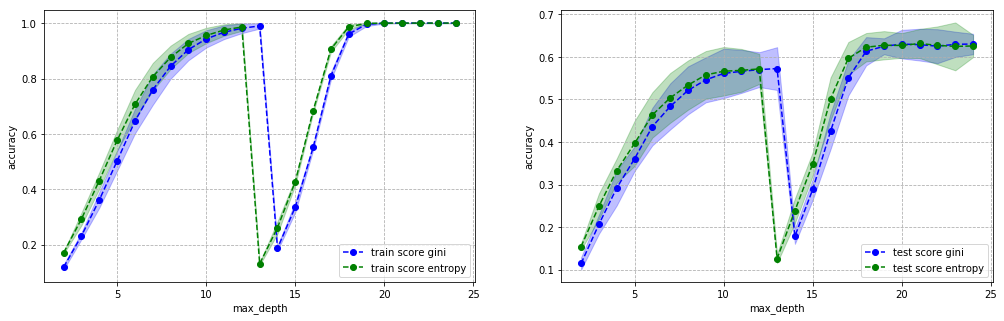

In [66]:
plot_grid_out(clf.cv_results_, c, l, x_space, xscale='linear', ylabel='max_depth')

### 3) Datos sin procesamiento

In [68]:
_, x_sub_unp, _, y_sub_unp = train_test_split(x_tr, y_tr, test_size=0.20, random_state=42)

In [69]:
tuned_parameters = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(2, 25)]
}]

clf = GridSearchCV(Tree(), tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_sub_unp, y_sub_unp)
clf.best_params_

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed: 62.7min finished


{'criterion': 'entropy', 'max_depth': 16}

In [71]:
clf.best_score_

0.63049283806749212

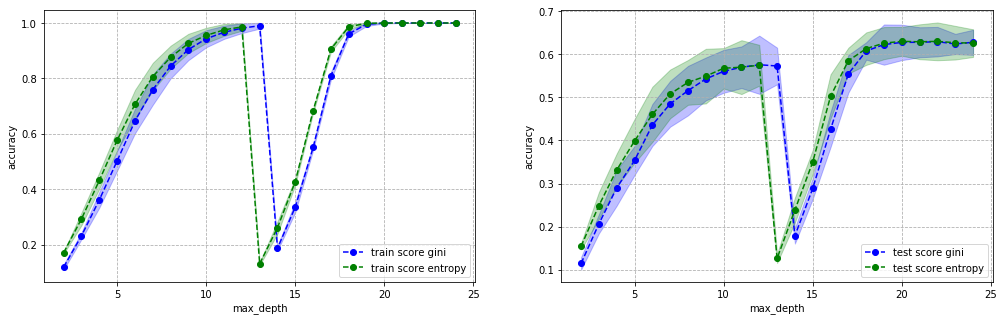

In [70]:
plot_grid_out(clf.cv_results_, c, l, x_space, xscale='linear', ylabel='max_depth')

### 4) Modelo Final

In [73]:
model = Tree()
model.set_params(max_depth=19,criterion='entropy') #'gini','entropy','variance'
model.fit(x_sub, y_sub)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [74]:
y_pred = model.predict(x_train_full)
acc_test = 100*accuracy_score(y_tr_f, y_pred)
print('Accuracy on test: %.2f%%' % (acc_test))
y_pred = model.predict(x_test)
acc_test = 100*accuracy_score(y_t, y_pred)
print('Accuracy on train: %.2f%%' % (acc_test))

Accuracy on test: 71.24%
Accuracy on train: 38.50%


## Extra Conv!

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator

In [6]:
X_train = x_tr.reshape(x_tr.shape[0], 28, 28, 1)
X_val = x_v.reshape(x_v.shape[0], 28, 28, 1)
X_test = x_t.reshape(x_t.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_val/=255
X_test/=255

In [7]:
Y_train = to_categorical(y_tr)
Y_val = to_categorical(y_v)
Y_test = to_categorical(y_t)

In [104]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(25))

model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
__________

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [10]:
hist2 = model.fit(X_train, Y_train, batch_size=64, epochs=5,
                  validation_data=(X_val, Y_val), shuffle=True, verbose=1)

Train on 20591 samples, validate on 6864 samples
Epoch 1/5
20591/20591 [==============================] - 166s 8ms/step - loss: 0.2077 - acc: 0.9489 - val_loss: 3.3090 - val_acc: 0.1256
Epoch 2/5
20591/20591 [==============================] - 161s 8ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 3/5
20591/20591 [==============================] - 161s 8ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 5.0268e-04 - val_acc: 1.0000
Epoch 4/5
20591/20591 [==============================] - 160s 8ms/step - loss: 6.4274e-04 - acc: 1.0000 - val_loss: 2.8953e-04 - val_acc: 1.0000
Epoch 5/5
20591/20591 [==============================] - 160s 8ms/step - loss: 4.1831e-04 - acc: 1.0000 - val_loss: 1.6799e-04 - val_acc: 1.0000


In [11]:
scores = model.evaluate(X_test, Y_test)
scores[1] * 100

7172/7172 [==============================] - 21s 3ms/step


96.249302844394862

In [59]:
scores

[7.3279173149453554, 0.037228109313998885]